### This notebook shows the core of the proposed framework: evaluation of ANN classifiers with latent space performance metrics

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from latentspace.ml_util import *
import latentspace.datasets as datasets
import latentspace.generative as generative
import latentspace.cnn as cnn
from latentspace.adversarial_generation import *
from latentspace.evaluation_util import EvaluationUtil

### Load a dataset and classifiers

In [3]:
from robustness import model_utils, datasets as robustness_datasets
DATA = 'ImageNet'
dataset_function = getattr(robustness_datasets, DATA)
DATA_PATH_DICT = {'ImageNet': './data/ImageNet'}
dataset = dataset_function(DATA_PATH_DICT[DATA])
model_kwargs = {'arch': 'resnet50', 'dataset': dataset, 'resume_path': f'./imagenet-models/ImageNet.pt'}
model, _ = model_utils.make_and_restore_model(**model_kwargs)
model = model.cpu()
model.eval();

=> loading checkpoint './imagenet-models/ImageNet.pt'
=> loaded checkpoint './imagenet-models/ImageNet.pt' (epoch 105)


In [4]:
dataset_info = DatasetInfo.ImageNet
label_indices = np.arange(1000)
no_classes = len(label_indices)
classifier_d = "mnist" # any value that can be accepted by a classifier
ds = datasets.ImageNetData(label_indices)
gm = generative.BigGAN(ds, 0.25) # set built-in decay factor
class_proportions = np.repeat(1 / no_classes, no_classes)

import json
with open("./data/ImageNet/imagenet1000_clsidx_to_labels.txt") as f: 
    imagenet_labels = f.read()
imagenet_labels = json.loads(imagenet_labels) 

*** Loading BigGAN...
{'dataset': 'I128_hdf5', 'augment': False, 'num_workers': 0, 'pin_memory': True, 'shuffle': True, 'load_in_mem': False, 'use_multiepoch_sampler': True, 'model': 'BigGAN', 'G_param': 'SN', 'D_param': 'SN', 'G_ch': 96, 'D_ch': 96, 'G_depth': 1, 'D_depth': 1, 'D_wide': True, 'G_shared': True, 'shared_dim': 128, 'dim_z': 120, 'z_var': 1.0, 'hier': True, 'cross_replica': False, 'mybn': False, 'G_nl': 'inplace_relu', 'D_nl': 'inplace_relu', 'G_attn': '64', 'D_attn': '64', 'norm_style': 'bn', 'seed': 0, 'G_init': 'ortho', 'D_init': 'ortho', 'skip_init': True, 'G_lr': 0.0001, 'D_lr': 0.0004, 'G_B1': 0.0, 'D_B1': 0.0, 'G_B2': 0.999, 'D_B2': 0.999, 'batch_size': 1, 'G_batch_size': 1, 'num_G_accumulations': 8, 'num_D_steps': 1, 'num_D_accumulations': 8, 'split_D': False, 'num_epochs': 100, 'parallel': False, 'G_fp16': False, 'D_fp16': False, 'D_mixed_precision': False, 'G_mixed_precision': False, 'accumulate_stats': False, 'num_standing_accumulations': 16, 'G_eval_mode': Tru

In [5]:
class Resize(torch.nn.Module):
    def __init__(self, side: int):
        super().__init__()
        self.side = side
    
    def forward(self, x: torch.Tensor):
        return torch.nn.functional.interpolate(x, size=(self.side, self.side),
                                               mode="bicubic", align_corners=False)

modelzoo_normalize_transform = torchvision.transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)

def normalize_modelzoo(x):
    # [-1, 1] -> [0, 1], then normalize
    # https://pytorch.org/docs/stable/torchvision/models.html
    return modelzoo_normalize_transform((x[0] + 1) / 2).unsqueeze(0)

def normalize_01(x):
    # [-1, 1] -> [0, 1]
    return (x + 1) / 2
    
class RobustnessClassifierWrapper(Trainer):
    def __init__(self, model):
        super().__init__(classifier_d, ds.get_train_loader, ds.get_test_loader, unit_type=0)
        self.model = torch.nn.Sequential(
            Resize(224),
            Lambda(normalize_01),
            model,
            Lambda(lambda x: x[0]),
        )
        
robust_classifiers = [RobustnessClassifierWrapper(model)]

mnist classifier: 23394 trainable parameters


In [6]:
import torchvision.models as models

#class PrintLayer(torch.nn.Module):
#    def forward(self, x):
#        print(x)
#        return x

class ModelZooClassifierWrapper(Trainer):
    def __init__(self, model, side: int):
        super().__init__(classifier_d, ds.get_train_loader, ds.get_test_loader, unit_type=0)
        self.model = torch.nn.Sequential(
            Resize(side),
            Lambda(normalize_modelzoo),
            model,
            #PrintLayer(),
        )

nonrobust_classifiers = [(models.squeezenet1_0, 256),   # error 41.90
                         (models.alexnet, 256),         # error 43.45
                         (models.resnet18, 224),        # error 30.24
                         (models.resnext50_32x4d, 224)] # error 21.49
nonrobust_classifiers = [ModelZooClassifierWrapper(m(pretrained=True), side)
                         for m, side in nonrobust_classifiers]
classifiers = nonrobust_classifiers + robust_classifiers
#classifiers = robust_classifiers

mnist classifier: 23394 trainable parameters
mnist classifier: 23394 trainable parameters
mnist classifier: 23394 trainable parameters
mnist classifier: 23394 trainable parameters


In [7]:
def advgen_experiments(adversary: Adversary, noise_eps: float, total_images: int):
    decay_factor = EpsDTransformer().eps_to_d(noise_eps)
    label_printer = lambda x: str(x.item()) #+ " " + imagenet_labels[str(x.item())]
    advgen = AdversarialGenerator(None, classifiers, True, decay_factor, label_printer)
    advgen.set_generative_model(gm)
    for i in np.random.choice(label_indices, size=total_images):
        no_images = 1
        LogUtil.info(f"*** CLASS {i}: {imagenet_labels[str(i)]} ***")
        gm.configure_label(i)
        advgen.generate(adversary, no_images, False, clear_stat=False)
    LogUtil.info("*** STATISTICS ***")
    advgen.print_stats(True)

### Quick demonstration how generative models and classifiers work

* For each class, show image reconstructions (as pairs original - reconstructed) and generated images

*** CLASS 681: notebook, notebook computer ***


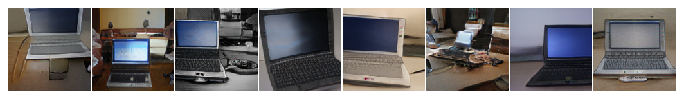

*** CLASS 684: ocarina, sweet potato ***


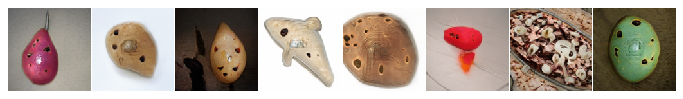

*** CLASS 212: English setter ***


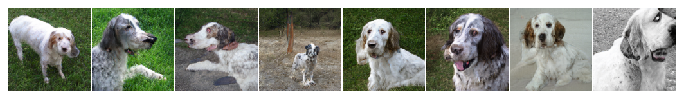

In [8]:
for i in np.random.choice(label_indices, size=3):
    LogUtil.info(f"*** CLASS {i}: {imagenet_labels[str(i)]} ***")
    gm.configure_label(i)
    EvaluationUtil.show_generated_images(gm, 1, 8)

### Measure latent adversarial accuracy (LGA)

In [ ]:
advgen_experiments(NopAdversary(), noise_eps=1.0, total_images=100)

### Measure latent adversarial generation severity (LAGS) by searching for minimum latent adversarial perturbations

* Change the number of images to get more meaningful results
* Metric reports are after each series of reconstructed/generated images
* Latent generation accuracy (LGA) is also computed
* Norms of minimum latent adversarial perturbations in the original space are also computed

In [ ]:
max_rho, noise_eps = 2.5, 1.0
adversary = PGDAdversary(max_rho, 50, 0.05, False, 0, verbose=0)   
advgen_experiments(adversary, noise_eps, total_images=600)

### Measure latent adversarial generation accuracy (LAGA) by searching for bounded latent adversarial perturbations

* Change the number of images to get more meaningful results
* Metric reports are after each series of reconstructed/generated images
* Latent generation accuracy (LGA) is also computed

In [ ]:
rho, noise_eps = 0.3, 1.0
# search with restarts (a sequence of restarts will terminate if an adversarial perturbation is found)
adversary = PGDAdversary(rho, 50, 0.05, True, 0, verbose=0, n_repeat=12, repeat_mode="any")
advgen_experiments(adversary, noise_eps, total_images=100)